In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW,SGD 

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json


from transformers import AutoTokenizer

In [2]:
import dependency_model as dep

# Auxiliar

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Procesado datos train: ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai_complete.json','r') as f:
    data = json.load(f)

In [6]:
# Utilizo convai2 para crear el vocabulario porque es el conjunto más grande de los usados
vocab = dep.Vocabulary(data,'relative')
convai_tokenized = dep.tokenize_dataset_with_dependencies(data,tokenizer,['to','as','about'],vocab)

In [7]:
convai_size = len(convai_tokenized)

In [8]:
val_size = round(convai_size *0.1)
train_size = convai_size - val_size

# Procesado datos evaluación: md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = dep.tokenize_dataset_with_dependencies(md_data,tokenizer,['to','as','about'],vocab)

# Creación dataloaders

In [11]:
convai_dataset = dep.CustomDataset(convai_tokenized,['to','as','about'],eval=False)
md_dataset = dep.CustomDataset(md_tokenized,['to','as','about'],eval=True)



In [12]:
convai_train, convai_val = torch.utils.data.random_split(convai_dataset,[train_size,val_size])

In [13]:
dl_train =DataLoader(convai_train,batch_size=64,shuffle=True,collate_fn=dep.collate_fn)
dl_val =DataLoader(convai_val,batch_size=64,shuffle=False,collate_fn=dep.collate_fn)
dl_eval =DataLoader(md_dataset,batch_size=64,shuffle=False,collate_fn=dep.collate_fn)

# Modelo

In [14]:
# Parámetros
hidden_dim = 128
embedding_dim = 100
model_name = "distilbert-base-uncased"
num_labels = 3
tasks = ['to','as','about']

In [15]:
model = dep.MultiWithDependencies(model_name, num_labels,tasks,vocab,embedding_dim,lstm_hidden_dim=hidden_dim).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
dep.eval_function_multi(model,dl_eval,tasks,"accuracy")

{'to': {'accuracy': 0.45580808080808083},
 'as': {'accuracy': 0.48239895697522817},
 'about': {'accuracy': 0.38137755102040816}}

In [17]:

# learning_rate = 5e-5
# optimizer = AdamW(model.parameters(),learning_rate)
# num_epochs = 30

# train_loss, val_loss = dep.train_functionV(model,num_epochs,dl_train,dl_val,optimizer=optimizer)
# torch.save(model.state_dict(),'distilbert_30_AW_DV')

# dep.plot_losses(train_loss,val_loss)

In [18]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(),learning_rate)
num_epochs = 10

train_loss, val_loss = dep.train_functionV(model,num_epochs,dl_train,dl_val,optimizer=optimizer)
torch.save(model.state_dict(),'distilbert_10_AW_DV')


  0%|          | 0/10330 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 1.9869995334141484 	 Validation loss: 1.945712307225103 
 10%|█         | 1033/10330 [02:01<18:10,  8.52it/s]
Epoch 2 	 Training loss: 1.9444649595720378 	 Validation loss: 1.951569265904634 
 20%|██        | 2066/10330 [04:05<16:14,  8.48it/s]
Epoch 3 	 Training loss: 1.9221645127422928 	 Validation loss: 1.946203527243241 
 30%|███       | 3099/10330 [06:09<14:12,  8.49it/s]
Epoch 4 	 Training loss: 1.9079354003230462 	 Validation loss: 1.9569535131039826 
 40%|████      | 4132/10330 [08:13<12:00,  8.61it/s]
Epoch 5 	 Training loss: 1.891896160274369 	 Validation loss: 1.9476213589958522 
 50%|█████     | 5165/10330 [10:16<09:58,  8.63it/s]
Epoch 6 	 Training loss: 1.8806600705697945 	 Validation loss: 1.9532402857490208 
 60%|██████    | 6198/10330 [12:19<08:00,  8.60it/s]
Epoch 7 	 Training loss: 1.8699832129916978 	 Validation loss: 1.954552678439928 
 70%|███████   | 7231/10330 [14:23<05:51,  8.81it/s]
Epoch 8 	 Training loss: 1.862097647390892 	 Validati

AttributeError: module 'dependency_model' has no attribute 'plot_losses'

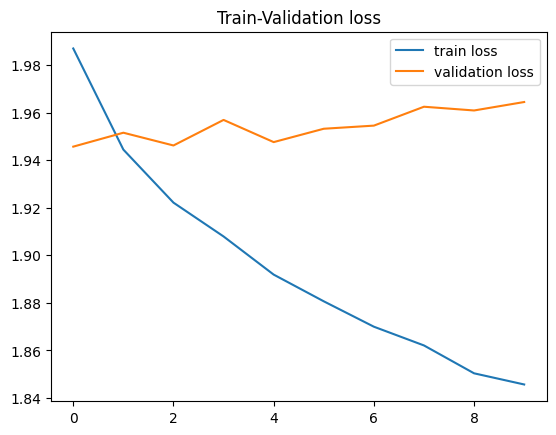

In [19]:

dep.plot_losses_val(train_loss,val_loss)

In [21]:
metrics = ["accuracy","f1","precision","recall"]
for metric in metrics:
    print(metric)
    print(dep.eval_function_multi(model,dl_eval,tasks,metric))
    print('\n')

accuracy
{'to': {'accuracy': 0.7411616161616161}, 'as': {'accuracy': 0.7040417209908736}, 'about': {'accuracy': 0.826530612244898}}


f1
{'to': {'f1': 0.7515151515151516}, 'as': {'f1': 0.7130214917825537}, 'about': {'f1': 0.8251928020565553}}


precision
{'to': {'precision': 0.748792270531401}, 'as': {'precision': 0.7139240506329114}, 'about': {'precision': 0.8147208121827412}}


recall
{'to': {'recall': 0.754257907542579}, 'as': {'recall': 0.7121212121212122}, 'about': {'recall': 0.8359375}}




In [ ]:
# model = dep.MultiWithDependencies(model_name, num_labels,tasks,vocab,embedding_dim,lstm_hidden_dim=hidden_dim).to(device)




# learning_rate = lr=5e-5
# optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# num_epochs = 30

# train_loss, val_loss = dep.train_function(model,num_epochs,dl_train,optimizer=optimizer)
# torch.save(model.state_dict(),'distilbert_30_SGD_DV')
# dep.plot_losses(train_loss,val_loss)


In [ ]:
# metrics = ["accuracy","f1","precision","recall"]
# for metric in metrics:
#     print(metric)
#     print(dep.eval_function_multi(model,dl_eval,tasks,metric))
#     print('\n')